# Investigating Which SAT Problems are Most Difficult to Solve

It is said that the hardest SAT problems are those with a clause/symbol ratio of 4.3. In this notebook, I will investigate this claim by analysing the difficulty of SAT problems using the complete DPLL and incomplete WalkSAT algorithms. 

In [2]:
INSTALL_PACKAGES=False
if INSTALL_PACKAGES:
    %pip install numpy
    %pip install matplotlib
    %pip install pandas
    %pip install tqdm
    %pip install scipy
    pass

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tqdm
import time
from scipy import stats
from scipy.interpolate import griddata, interp1d
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import timeit

## DPLL Algorithm
This was replaced by the Rust implementation.

In [4]:
def simplify(cnf, literal):
    cnf = [clause for clause in cnf if literal not in clause]
    cnf = [
        [other_literal for other_literal in clause if other_literal != -literal]
        for clause in cnf
    ]
    return cnf


def unit_propagation(cnf, assignment):
    """If any clause is a literal, assign that literal to True and simplify the CNF"""
    changed = True
    while changed:
        changed = False
        for clause in cnf:
            unassigned = [
                literal
                for literal in clause
                if literal not in assignment and -literal not in assignment
            ]
            if len(unassigned) == 1:
                literal = unassigned[0]
                assignment[abs(literal)] = literal > 0
                changed = True
                cnf = simplify(cnf, literal)
                if not cnf:
                    return cnf, assignment
                break
    return cnf, assignment


def pure_literal_elimination(cnf, assignment):
    all_literals = {literal for clause in cnf for literal in clause}

    for literal in all_literals:
        if -literal not in all_literals:
            assignment[abs(literal)] = literal > 0
            cnf = simplify(cnf, literal)

    return cnf, assignment


def dpll(cnf, input_assignment=None):
    if input_assignment is None:
        input_assignment = {}

    cnf, assignment = unit_propagation(cnf, input_assignment)

    cnf, assignment = pure_literal_elimination(cnf, assignment)

    if not cnf:
        return True, assignment

    if any(len(clause) == 0 for clause in cnf):
        return False, {}

    unassigned_vars = {
        abs(literal)
        for clause in cnf
        for literal in clause
        if abs(literal) not in assignment
    }
    chosen_var = unassigned_vars.pop()

    assignment[chosen_var] = True
    simplified_cnf = simplify(cnf, chosen_var)
    result, final_assignment = dpll(simplified_cnf, assignment.copy())
    if result:
        return True, final_assignment

    assignment[chosen_var] = False
    simplified_cnf = simplify(cnf, -chosen_var)
    return dpll(simplified_cnf, assignment.copy())

## WalkSAT Algorithm
This was replaced by the Rust implementation.

In [5]:
def is_clause_satisfied(clause, assignment):
    return any(literal in assignment and assignment[literal] for literal in clause)


def count_unsat_clauses(clauses, assignment):
    return sum(not is_clause_satisfied(clause, assignment) for clause in clauses)


def count_unsat_clauses_if_flipped(var, clauses, assignment):
    flipped_assignment = assignment.copy()
    flipped_assignment[var] = not flipped_assignment.get(var, False)
    return count_unsat_clauses(clauses, flipped_assignment)


def walksat(cnf, max_flips=1000, noise=0.5):
    all_variables = {abs(literal) for clause in cnf for literal in clause}

    # Initialize random assignment
    assignment = {var: random.choice([True, False]) for var in all_variables}

    for _ in range(max_flips):
        unsatisfied_clauses = [
            clause for clause in cnf if not is_clause_satisfied(clause, assignment)
        ]

        if not unsatisfied_clauses:
            return True, assignment

        clause = random.choice(unsatisfied_clauses)

        if random.random() < noise:
            var = abs(random.choice(clause)) # Random walk
        else:
            # Flip the variable that minimizes the number of unsatisfied clauses
            var = abs(
                min(
                    clause,
                    key=lambda v: count_unsat_clauses_if_flipped(v, cnf, assignment),
                )
            )

        assignment[var] = not assignment[var]

    return False, {}

## Data Processing

In [6]:
def random_cnf(num_clauses, num_symbols):
    vars = list(range(1, num_symbols + 1))
    cnf = []
    for _ in range(num_clauses):
        clause = [-i if random.random() < 0.5 else i for i in vars]
        cnf.append(clause)
    return cnf

In [7]:
def process_combination(num_symbols, num_clauses, algorithm):
    cnf = random_cnf(num_clauses, num_symbols)
    if algorithm == "dpll":
        func = lambda: dpll(cnf)
    elif algorithm == "walksat":
        func = lambda: walksat(cnf)
    algo_time = timeit.timeit(func, number=1)
    # walksat_time = measureTime(walksat, cnf)
    return {
        "num_symbols": num_symbols,
        "num_clauses": num_clauses,
        "time": algo_time,
        "algorithm": algorithm,
        "solved": func()[0],
    }

In [197]:
CALCULATE = False  # Whether to calculate the data or load it from a file
if CALCULATE:
    csv_file = ".\\data.csv"
    data_frame = pd.DataFrame(
        columns=["num_symbols", "num_clauses", "time", "algorithm"]
    )
    data_frame["algorithm"] = data_frame["algorithm"].astype(str)
    for num_symbols in tqdm.tqdm(range(3, 50, 1)):
        for num_clauses in range(3, 50, 1):
            for i in range(10):
                for algorithm in ["dpll"]:
                    data_frame.loc[len(data_frame)] = process_combination(
                        num_symbols, num_clauses, algorithm
                    )
    data_frame.to_csv(csv_file, index=False)
else:
    csv_file = "..\\RustCode\\results.csv"
    data_frame = pd.read_csv(csv_file)

data_frame["clause_symbol_ratio"] = (
    data_frame["num_clauses"] / data_frame["num_symbols"]
)

In [198]:
clean = True  # Whether to clean the data or not. If True, it will remove outliers above 2 standard deviations

dpll_df = data_frame[data_frame["algorithm"] == "dpll"]
walksat_df = data_frame[data_frame["algorithm"] == "walksat"]


def clean_df(df, threshold=2):
    z_scores = np.abs(stats.zscore(df["time"]))
    return df[(z_scores < threshold)]


if clean:
    dpll_df_clean = clean_df(dpll_df)
    walksat_df_clean = clean_df(walksat_df)
else:
    dpll_df_clean = dpll_df
    walksat_df_clean = walksat_df

## Displaying Data

In [189]:
def get_magnitude(x):
    return int(np.floor(np.log10(x)))


def to1sf(x):
    magnitude = get_magnitude(x)
    scaled = x / 10**magnitude
    return round(scaled, 1) * 10**magnitude


def to1sf_down(x):
    magnitude = get_magnitude(x)
    scaled = x / 10**magnitude
    return np.floor(scaled) * 10**magnitude


def to1sf_up(x):
    magnitude = get_magnitude(x)
    scaled = x / 10**magnitude
    return np.ceil(scaled) * 10**magnitude


def get_levels(data, scale=1):
    data_max = np.max(data)
    result = (np.linspace(0, to1sf(data_max), 5) * scale)[1:]
    return result

In [195]:
def plot_clauses_symbols_heatmap(df, ax, plt, smooth=True):
    num_symbols = df["num_symbols"].values
    num_clauses = df["num_clauses"].values
    num_time = df["time"].values

    num_symbols_unique = np.unique(num_symbols)
    num_clauses_unique = np.unique(num_clauses)
    X, Y = np.meshgrid(num_symbols_unique, num_clauses_unique)

    Z = griddata((num_symbols, num_clauses), num_time, (X, Y), method="cubic")
    if smooth:
        Z_smooth = gaussian_filter(Z, sigma=2)
    else:
        Z_smooth = Z

    heatmap = ax.pcolormesh(X, Y, Z_smooth, shading="auto")
    levels = get_levels(Z_smooth)
    contours = ax.contour(
        X, Y, Z_smooth, colors="black", linewidths=0.5, levels=levels
    )
    ax.clabel(contours, inline=True, fontsize=8)
    ax.set_xlabel("Number of symbols")
    ax.set_ylabel("Number of clauses")
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label("Time (s)")
    cbar.set_ticks(levels)

In [191]:
def resample_line(x, y, num_points=100):
    distances = np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2)
    t = np.concatenate(([0], np.cumsum(distances)))

    interp_x = interp1d(t, x)
    interp_y = interp1d(t, y)

    new_t = np.linspace(0, t[-1], num_points)

    return interp_x(new_t), interp_y(new_t)

In [192]:
def gaussian_blur(array, repeats=1, sigma=1, fade_distance=1.0, fade_profile=1.0):
    fade_distance = np.clip(fade_distance, 0, 1)
    fade_length = int(len(array) * fade_distance / 2)
    mix = np.ones(len(array))

    if fade_length > 0:
        mix[:fade_length] = 1-(1 - np.linspace(0, 1, fade_length) ** (1/fade_profile))**fade_profile
        mix[-fade_length:] = 1-(1 - np.linspace(1, 0, fade_length) ** (1/fade_profile))**fade_profile

    blurred_array = array.copy()
    for _ in range(repeats):
        blurred_array = gaussian_filter1d(blurred_array, sigma=sigma)
        blurred_array = mix * blurred_array + (1 - mix) * array

    return blurred_array

In [193]:
from matplotlib.axes import Axes


def math_text_sci_notation(x):
    magnitude = get_magnitude(x)
    scaled = x / 10**magnitude
    return f"${scaled:.1f} \\times 10^{{{magnitude}}}$"


def plot_ratio_time_scatter(df, ax: Axes, label=None):
    x = df["clause_symbol_ratio"]
    y = df["time"]

    ax.scatter(x, y, alpha=0.05, s=1)
    
    new_df = df.copy()
    new_df = new_df.groupby("clause_symbol_ratio")[["time"]].median().reset_index()
    new_df.sort_values(by="clause_symbol_ratio")

    x = new_df["clause_symbol_ratio"]
    y = new_df["time"]

    y_smoothed = gaussian_blur(y, repeats=1, sigma=2, fade_distance=0)
    spaced_x, spaced_y = resample_line(x, y_smoothed, num_points=1000)
    spaced_y = gaussian_blur(
        spaced_y, repeats=5, sigma=20, fade_distance=0.2, fade_profile=2
    )
    spaced_y = gaussian_blur(
        spaced_y, repeats=5, sigma=5, fade_distance=0.2, fade_profile=2
    )

    max_index = np.argmax(spaced_y)
    max_x = spaced_x[max_index]
    max_y = spaced_y[max_index]
    ax.scatter(max_x, max_y, c="black", s=5, zorder=10)
    annotation = f"({max_x:.1f}, {max_y*10**6:.1f} μs)"
    ax.annotate(
        annotation,
        (max_x, max_y),
        textcoords="offset points",
        xytext=(0, 5),
        ha="right",
        fontsize=8,
    )

    ax.plot(spaced_x, spaced_y, label=label)
    ax.legend(loc="upper right")
    
def plot_prop_solved(df, ax: Axes):
    ax2 = ax.twinx()
    new_df = df.groupby("clause_symbol_ratio")[["solved"]].mean().reset_index()
    print(new_df.describe())
    x = new_df["clause_symbol_ratio"]
    y = new_df["solved"]
    ax2.plot(x, y)

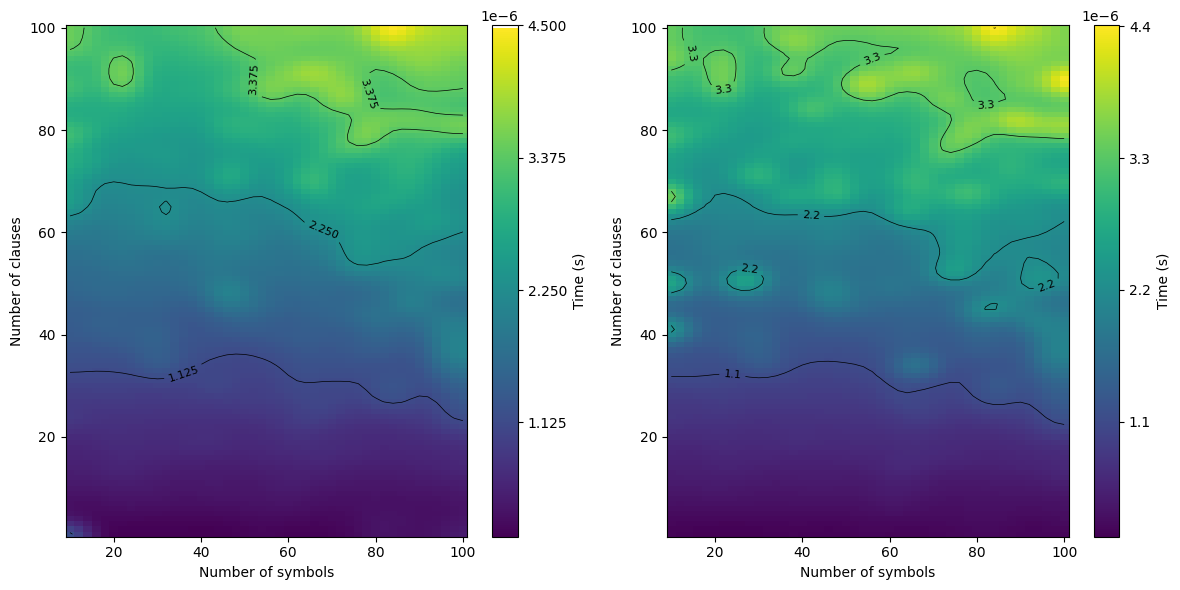

In [202]:
from matplotlib.axis import Axis
from matplotlib.figure import Figure


def plot_times(df, fig: Figure, ax: Axis, title=None, vmax=None):
    for i in [5, 10, 15, 20]:
        interest = df[(df["num_symbols"] == i)]
        if interest.empty:
            continue
        interest = interest.sort_values(by="clause_symbol_ratio")

        label = f"{i} symbols"
        plot_ratio_time_scatter(interest, ax, label)

    ax.set_xlabel("Clause/Symbol Ratio")
    ax.set_ylabel("Time / µs")
    if vmax:
        ax.set_ylim(0, vmax)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1000000:.1f}"))
    if title:
        ax.set_title(title)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# ax1.set_ylim(0, 0.00003)
# ax2.set_ylim(0, 0.0001)

# plot_times(dpll_df_clean, fig, ax1, title="DPLL")
# plot_times(walksat_df_clean, fig, ax2, title="WalkSAT")

# fig.suptitle(
#     "Time vs Clause/Symbol Ratio for DPLL and WalkSAT solvers, grouped by number of symbols"
# )

plot_clauses_symbols_heatmap(dpll_df_clean, ax1, plt, smooth=True)
plot_clauses_symbols_heatmap(walksat_df_clean, ax2, plt, smooth=True)

fig.tight_layout()
fig.savefig("plot.svg", format="svg")
plt.show()